# Importing Packages

In [ ]:
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.optimizers import  RMSprop
import matplotlib.pyplot as plt
import numpy as np
import random
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers.merge import concatenate
from keras import metrics as MT
from keras import regularizers

# Downloading Data

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!cp kaggle.json ~/.kaggle/


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d techsash/waste-classification-data

 99% 421M/427M [00:16<00:00, 20.3MB/s]
100% 427M/427M [00:16<00:00, 27.7MB/s]


In [ ]:
!unzip 'waste-classification-data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: dataset/DATASET/TRAIN/R/R_5499.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5512.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5513.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5514.jpg  
  i

# Importing Dataset

In [ ]:
batch_size = 32
img_size = 224 
Epochs = 30

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/dataset/DATASET/TRAIN',
  seed=123,
  image_size=(img_size, img_size),

  batch_size=batch_size,
#     label_mode='categorical'
)


Found 22564 files belonging to 2 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/dataset/DATASET/TEST',
  batch_size = batch_size,
  seed=123,
  image_size=(img_size, img_size))

Found 2513 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['O', 'R']


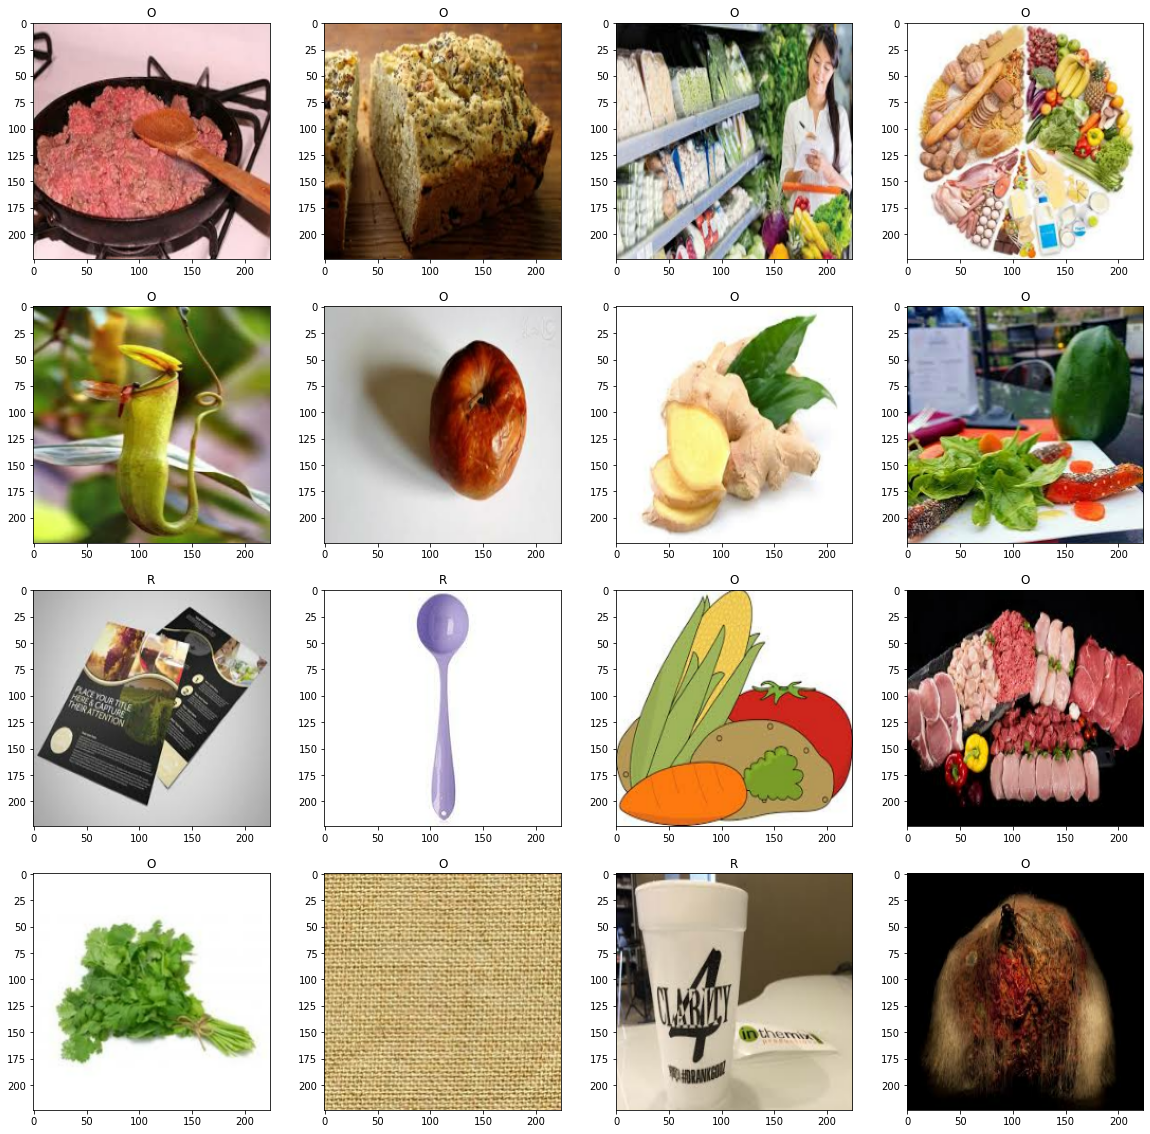

In [ ]:
j = 0
plt.figure(figsize= (20,20))
for image , label in train_ds.take(1): ## Here take is for choosing only one batch. Ignore it and it will take all batches. Note that each batch contains 32 images.
    for i in random.sample(range(32),16):  
        ax = plt.subplot(4,4,j+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        j = j+1
plt.show()

# Inception V3 (New Version Of GoogleNet) 

## Fine-tuning

### Model Generation

**create the base pre-trained model**

In [ ]:
base_model = InceptionV3(include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


**Adding a global spatial average pooling layer**

In [ ]:
Input_layer = tf.keras.layers.Input(shape = (224,224,3))
x = tf.keras.applications.inception_v3.preprocess_input(Input_layer)
x = base_model(x)
x = GlobalAveragePooling2D()(x)

**Adding a fully-connected layer + Drop Out**

In [ ]:
x = Dense(1024,
          activation='relu',
         )(x)
x = tf.keras.layers.Dropout(0.4)(x)

**Adding a logistic layer (As Predictor) -- we have 2 classes**

In [ ]:
predictions = Dense(1,
                    activation='sigmoid',
                   )(x)


**this is the model we will train**

In [ ]:
model = Model(inputs = Input_layer , outputs = predictions)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

**Visializing model as a Tree**

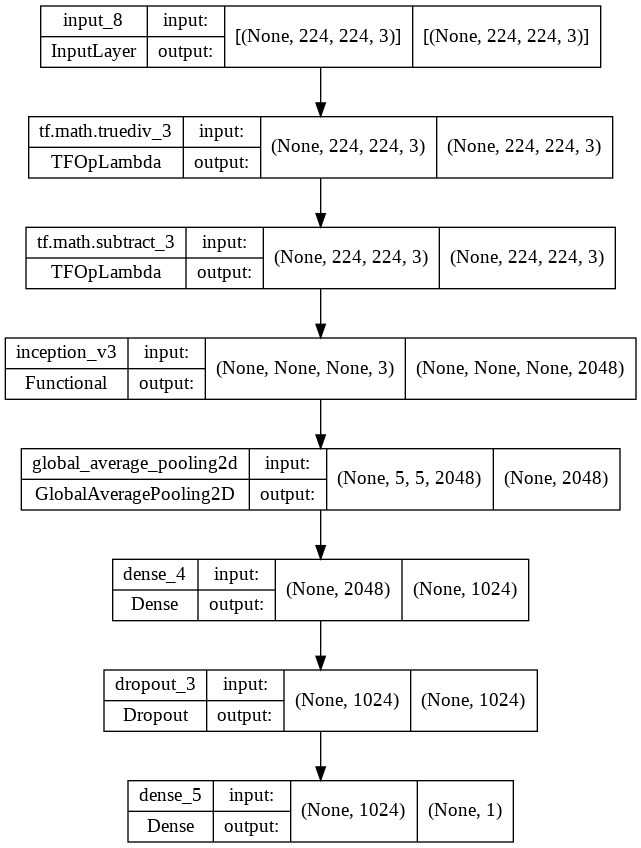

In [ ]:
tf.keras.utils.plot_model(model, to_file='CurrentModel.png', show_shapes=True)

### Train Phase

**We Set all Trainable part True so model can be trained** 

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

**We use RMSProp due to it's power and add high momentum and low learning rate to reach best operation** 

####_learning rate = 1e-7 , momentum = 0.9_

In [ ]:
model.compile(
    optimizer= tf.keras.optimizers.RMSprop(learning_rate = 1e-7 , momentum = 0.9),
    loss= tf.keras.losses.BinaryCrossentropy(),
    metrics = [
               tf.keras.metrics.BinaryAccuracy(),
               tf.keras.metrics.AUC()
    ]
)

In [ ]:
with tf.device('/device:GPU:0'):
    hist = model.fit(
          train_ds,
          epochs = Epochs ,
         validation_data=val_ds
      )
model.save_weights('Fine_tuning_weights_without_callbacks.h5')

Epoch 1/30
706/706 [==============================] - 200s 259ms/step - loss: 0.5181 - binary_accuracy: 0.7575 - auc: 0.8401 - val_loss: 0.4084 - val_binary_accuracy: 0.8217 - val_auc: 0.9412
Epoch 2/30
706/706 [==============================] - 185s 261ms/step - loss: 0.3164 - binary_accuracy: 0.8869 - auc: 0.9493 - val_loss: 0.3160 - val_binary_accuracy: 0.8739 - val_auc: 0.9593
Epoch 3/30
706/706 [==============================] - 185s 262ms/step - loss: 0.2457 - binary_accuracy: 0.9095 - auc: 0.9656 - val_loss: 0.2828 - val_binary_accuracy: 0.8882 - val_auc: 0.9668
Epoch 4/30
706/706 [==============================] - 185s 262ms/step - loss: 0.2087 - binary_accuracy: 0.9204 - auc: 0.9738 - val_loss: 0.2624 - val_binary_accuracy: 0.9005 - val_auc: 0.9721
Epoch 5/30
706/706 [==============================] - 185s 262ms/step - loss: 0.1918 - binary_accuracy: 0.9270 - auc: 0.9771 - val_loss: 0.2528 - val_binary_accuracy: 0.9041 - val_auc: 0.9753
Epoch 6/30
706/706 [====================

##### Model Performance Plot

In [ ]:
Evals = list(hist.history.keys())

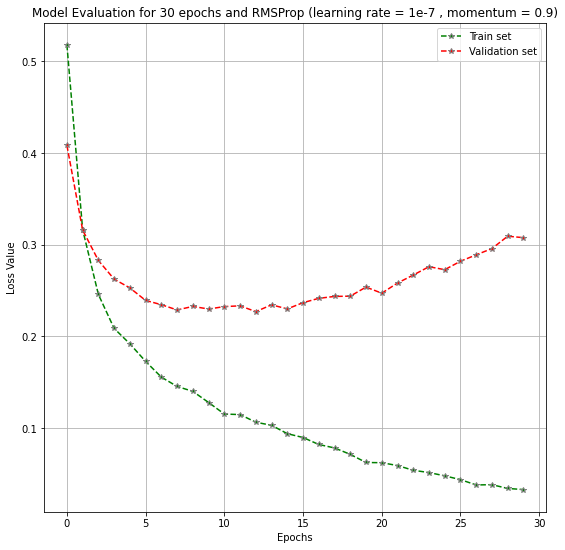

In [ ]:
plt.figure(figsize = (9,9))
plt.title(f'Model Evaluation for {Epochs} epochs and RMSProp (learning rate = 1e-7 , momentum = 0.9)')
plt.plot(hist.history[Evals[0]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(hist.history[Evals[3]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('Loss Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()

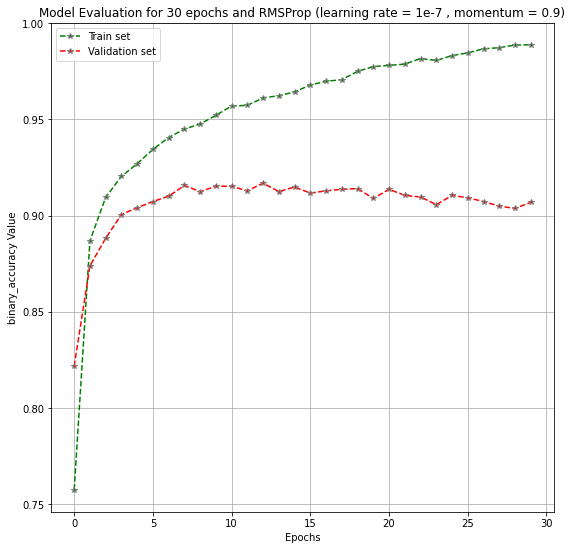

In [ ]:
plt.figure(figsize = (9,9))
plt.title(f'Model Evaluation for {Epochs} epochs and RMSProp (learning rate = 1e-7 , momentum = 0.9)')
plt.plot(hist.history[Evals[1]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(hist.history[Evals[4]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('binary_accuracy Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()

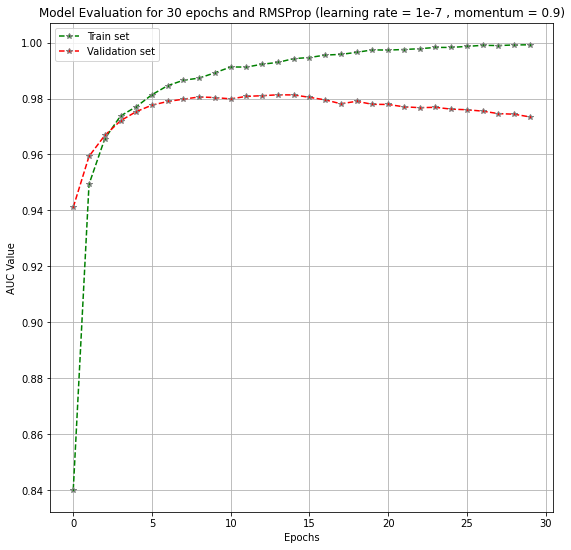

In [ ]:
plt.figure(figsize = (9,9))
plt.title(f'Model Evaluation for {Epochs} epochs and RMSProp (learning rate = 1e-7 , momentum = 0.9)')
plt.plot(hist.history[Evals[2]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(hist.history[Evals[5]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('AUC Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()

####_learning rate = 1e-5 , momentum = 0.8_

In [ ]:
MODEL = tf.keras.models.clone_model(model)

In [ ]:
MODEL.compile(
    optimizer= tf.keras.optimizers.RMSprop(learning_rate = 1e-5 , momentum = 0.8),
    loss= tf.keras.losses.BinaryCrossentropy(),
    metrics = [
               tf.keras.metrics.BinaryAccuracy(),
               tf.keras.metrics.AUC()
    ]
)
callback = [tf.keras.callbacks.ReduceLROnPlateau() , tf.keras.callbacks.EarlyStopping(patience = 5 , restore_best_weights = True )]

In [ ]:
with tf.device('/device:GPU:0'):
    hist2 = MODEL.fit(
          train_ds,
          epochs = Epochs ,
          callbacks = callback,
         validation_data=val_ds
      )
MODEL.save_weights('Fine_tuning_weights_with_callbacks.h5')

Epoch 1/30
706/706 [==============================] - 200s 268ms/step - loss: 0.4209 - binary_accuracy: 0.8165 - auc_4: 0.8910 - val_loss: 0.3607 - val_binary_accuracy: 0.8325 - val_auc_4: 0.9228 - lr: 1.0000e-05
Epoch 2/30
706/706 [==============================] - 185s 262ms/step - loss: 0.3673 - binary_accuracy: 0.8477 - auc_4: 0.9168 - val_loss: 0.4116 - val_binary_accuracy: 0.8245 - val_auc_4: 0.9458 - lr: 1.0000e-05
Epoch 3/30
706/706 [==============================] - 185s 262ms/step - loss: 0.3337 - binary_accuracy: 0.8603 - auc_4: 0.9315 - val_loss: 0.3399 - val_binary_accuracy: 0.8440 - val_auc_4: 0.9363 - lr: 1.0000e-05
Epoch 4/30
706/706 [==============================] - 185s 262ms/step - loss: 0.3136 - binary_accuracy: 0.8722 - auc_4: 0.9396 - val_loss: 0.2486 - val_binary_accuracy: 0.9041 - val_auc_4: 0.9656 - lr: 1.0000e-05
Epoch 5/30
706/706 [==============================] - 185s 261ms/step - loss: 0.2940 - binary_accuracy: 0.8816 - auc_4: 0.9467 - val_loss: 0.2818 - 

##### Model Performance Plot

In [ ]:
Evals = list(hist2.history.keys())

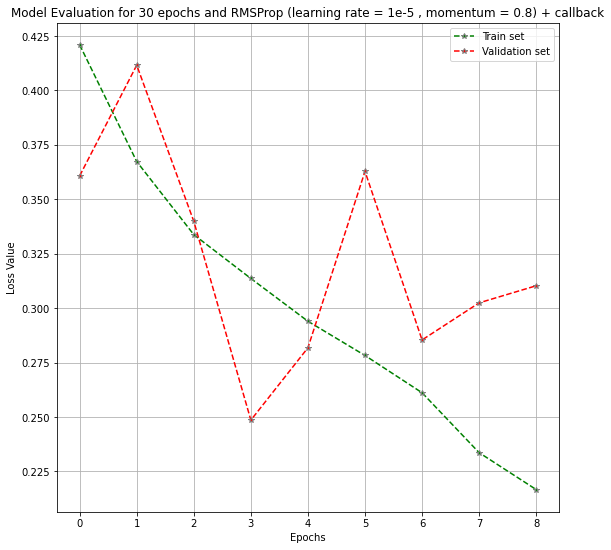

In [ ]:
plt.figure(figsize = (9,9))
plt.title(f'Model Evaluation for {Epochs} epochs and RMSProp (learning rate = 1e-5 , momentum = 0.8) + callback')
plt.plot(hist2.history[Evals[0]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(hist2.history[Evals[3]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('Loss Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()

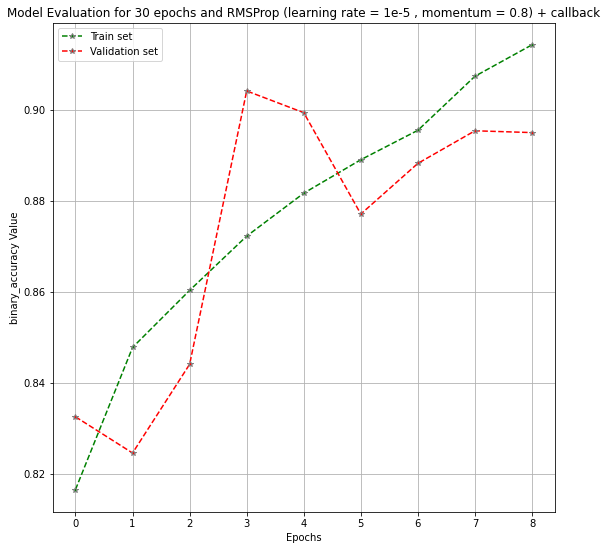

In [ ]:
plt.figure(figsize = (9,9))
plt.title(f'Model Evaluation for {Epochs} epochs and RMSProp (learning rate = 1e-5 , momentum = 0.8) + callback')
plt.plot(hist2.history[Evals[1]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(hist2.history[Evals[4]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('binary_accuracy Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()

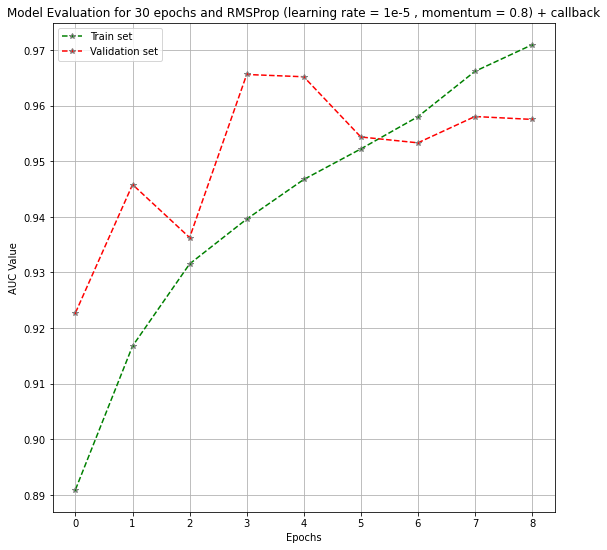

In [ ]:
plt.figure(figsize = (9,9))
plt.title(f'Model Evaluation for {Epochs} epochs and RMSProp (learning rate = 1e-5 , momentum = 0.8) + callback')
plt.plot(hist2.history[Evals[2]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(hist2.history[Evals[5]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('AUC Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()

## Transfer Learning

### Model Generation

**Using Same Architecture**

In [ ]:
base_model2 = InceptionV3(include_top=False , weights = 'imagenet')
Input_layer1 = tf.keras.layers.Input(shape = (224,224,3))
x1 = tf.keras.applications.inception_v3.preprocess_input(Input_layer1)
x1 = base_model2(x1)
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(1024,
          activation='relu',
         )(x1)
x1 = tf.keras.layers.Dropout(0.4)(x1)
predictions2 = Dense(1,
                    activation='sigmoid',
                   )(x1)
model = tf.keras.models.Model(inputs=Input_layer1, outputs=predictions2)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

### Train Phase

**first: train only the top layers (which were randomly initialized) i.e. freeze all convolutional InceptionV3 layers**

In [ ]:
for layer in base_model2.layers:
    layer.trainable = False

**compile the model (should be done *after* setting layers to non-trainable)**

In [ ]:
model.compile(
    optimizer= tf.keras.optimizers.RMSprop(learning_rate = 1e-7 , momentum = 0.9),
    loss= tf.keras.losses.BinaryCrossentropy(),
    metrics = [
               tf.keras.metrics.BinaryAccuracy(),
               tf.keras.metrics.AUC()
               
])


**train the model on the new data for a few epochs**


In [ ]:
with tf.device('/device:GPU:0'):
    hist_partA = model.fit(
          train_ds,
          epochs = 10 ,
          validation_data=val_ds
      )
model.save_weights('Transfer_learning_weights_partA.h5')

Epoch 1/10
706/706 [==============================] - 80s 91ms/step - loss: 0.6134 - binary_accuracy: 0.6629 - auc: 0.7170 - val_loss: 0.4342 - val_binary_accuracy: 0.8563 - val_auc: 0.9399
Epoch 2/10
706/706 [==============================] - 62s 88ms/step - loss: 0.4552 - binary_accuracy: 0.7964 - auc: 0.8764 - val_loss: 0.3483 - val_binary_accuracy: 0.8910 - val_auc: 0.9617
Epoch 3/10
706/706 [==============================] - 63s 89ms/step - loss: 0.3753 - binary_accuracy: 0.8484 - auc: 0.9217 - val_loss: 0.3077 - val_binary_accuracy: 0.9001 - val_auc: 0.9659
Epoch 4/10
706/706 [==============================] - 63s 89ms/step - loss: 0.3284 - binary_accuracy: 0.8732 - auc: 0.9397 - val_loss: 0.2866 - val_binary_accuracy: 0.9021 - val_auc: 0.9674
Epoch 5/10
706/706 [==============================] - 63s 89ms/step - loss: 0.2996 - binary_accuracy: 0.8856 - auc: 0.9491 - val_loss: 0.2775 - val_binary_accuracy: 0.9005 - val_auc: 0.9685
Epoch 6/10
706/706 [==============================

In [ ]:
Evals = list(hist_partA.history.keys())

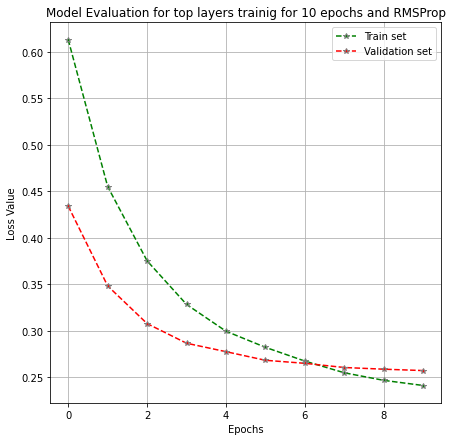

In [ ]:
plt.figure(figsize = (7,7))
plt.title(f'Model Evaluation for top layers trainig for {10} epochs and RMSProp')
plt.plot(hist_partA.history[Evals[0]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(hist_partA.history[Evals[3]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('Loss Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()

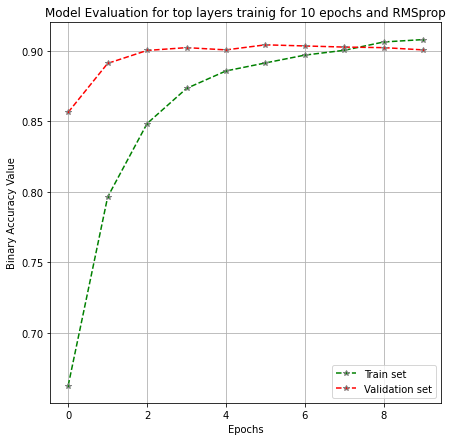

In [ ]:
plt.figure(figsize = (7,7))
plt.title(f'Model Evaluation for top layers trainig for {10} epochs and RMSprop')
plt.plot(hist_partA.history[Evals[1]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(hist_partA.history[Evals[4]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('Binary Accuracy Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()

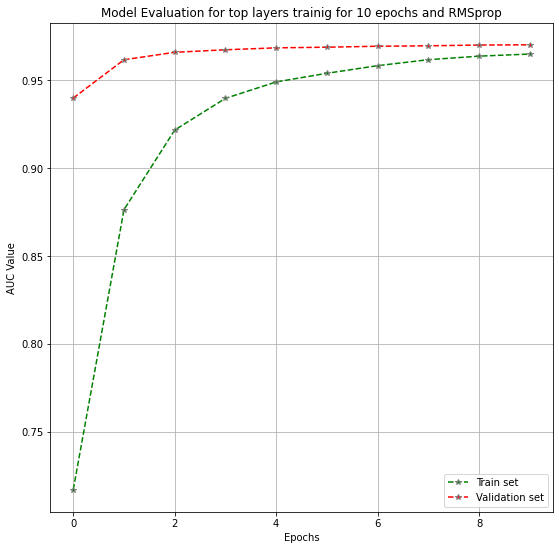

In [ ]:
plt.figure(figsize = (9,9))
plt.title(f'Model Evaluation for top layers trainig for {10} epochs and RMSprop')
plt.plot(hist_partA.history[Evals[2]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(hist_partA.history[Evals[5]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('AUC Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()

_at this point, the top layers are well trained and we can start fine-tuning convolutional layers from inception V3. We will freeze the bottom N layers and train the remaining top layers._

**let's visualize layer names and layer indices to see how many layers we should freeze:**

In [ ]:
for i, layer in enumerate(base_model2.layers):
    print(i, layer.name)

0 input_3
1 conv2d_94
2 batch_normalization_94
3 activation_94
4 conv2d_95
5 batch_normalization_95
6 activation_95
7 conv2d_96
8 batch_normalization_96
9 activation_96
10 max_pooling2d_4
11 conv2d_97
12 batch_normalization_97
13 activation_97
14 conv2d_98
15 batch_normalization_98
16 activation_98
17 max_pooling2d_5
18 conv2d_102
19 batch_normalization_102
20 activation_102
21 conv2d_100
22 conv2d_103
23 batch_normalization_100
24 batch_normalization_103
25 activation_100
26 activation_103
27 average_pooling2d_9
28 conv2d_99
29 conv2d_101
30 conv2d_104
31 conv2d_105
32 batch_normalization_99
33 batch_normalization_101
34 batch_normalization_104
35 batch_normalization_105
36 activation_99
37 activation_101
38 activation_104
39 activation_105
40 mixed0
41 conv2d_109
42 batch_normalization_109
43 activation_109
44 conv2d_107
45 conv2d_110
46 batch_normalization_107
47 batch_normalization_110
48 activation_107
49 activation_110
50 average_pooling2d_10
51 conv2d_106
52 conv2d_108
53 conv2d

**we will freeze the first N_layer ( default is 249 i.e. we chose to train the top 2 inception blocks)) layers and unfreeze the rest:**

In [ ]:
N_layer = 249
for layer in model.layers[:N_layer]:
    layer.trainable = False
for layer in model.layers[N_layer:]:
    layer.trainable = True

In [ ]:
model.compile(
    optimizer= tf.keras.optimizers.RMSprop(learning_rate = 1e-5 , momentum = 0.9),
    loss= tf.keras.losses.BinaryCrossentropy(),
    metrics = [
               tf.keras.metrics.BinaryAccuracy(),
               tf.keras.metrics.AUC()
    ]
)

In [ ]:
with tf.device('/device:GPU:0'):
    hist_transfer = model.fit(
          train_ds,
          epochs = Epochs ,
         validation_data=val_ds
      )
callback = [tf.keras.callbacks.ReduceLROnPlateau() , tf.keras.callbacks.EarlyStopping()]
model.save_weights('Transfer_learning_weights_partB.h5')

Epoch 1/30
706/706 [==============================] - 70s 93ms/step - loss: 0.2331 - binary_accuracy: 0.9115 - auc_3: 0.9675 - val_loss: 0.2572 - val_binary_accuracy: 0.9005 - val_auc_3: 0.9702
Epoch 2/30
706/706 [==============================] - 65s 91ms/step - loss: 0.2363 - binary_accuracy: 0.9101 - auc_3: 0.9661 - val_loss: 0.2572 - val_binary_accuracy: 0.9005 - val_auc_3: 0.9702
Epoch 3/30
706/706 [==============================] - 65s 91ms/step - loss: 0.2366 - binary_accuracy: 0.9101 - auc_3: 0.9661 - val_loss: 0.2572 - val_binary_accuracy: 0.9005 - val_auc_3: 0.9702
Epoch 4/30
706/706 [==============================] - 65s 91ms/step - loss: 0.2353 - binary_accuracy: 0.9108 - auc_3: 0.9664 - val_loss: 0.2572 - val_binary_accuracy: 0.9005 - val_auc_3: 0.9702
Epoch 5/30
706/706 [==============================] - 64s 90ms/step - loss: 0.2371 - binary_accuracy: 0.9105 - auc_3: 0.9659 - val_loss: 0.2572 - val_binary_accuracy: 0.9005 - val_auc_3: 0.9702
Epoch 6/30
706/706 [==========

In [ ]:
Evals = list(hist_transfer.history.keys())

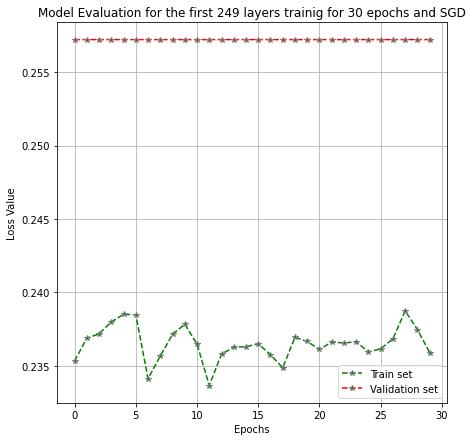

In [ ]:
plt.figure(figsize = (7,7))
plt.title(f'Model Evaluation for the first {N_layer} layers trainig for {Epochs} epochs and RMSprop')
plt.plot(hist_transfer.history[Evals[0]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(hist_transfer.history[Evals[3]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('Loss Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()

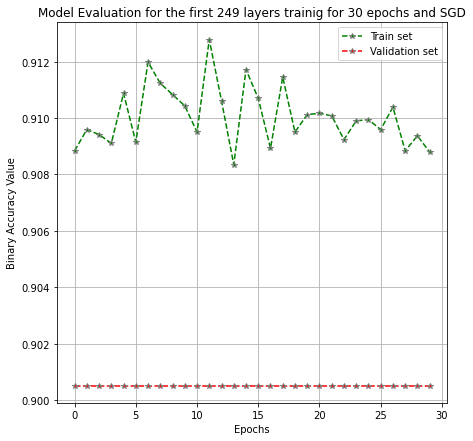

In [ ]:
plt.figure(figsize = (7,7))
plt.title(f'Model Evaluation for the first {N_layer} layers trainig for {Epochs} epochs and RMSprop')
plt.plot(hist_transfer.history[Evals[1]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(hist_transfer.history[Evals[4]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('Binary Accuracy Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()

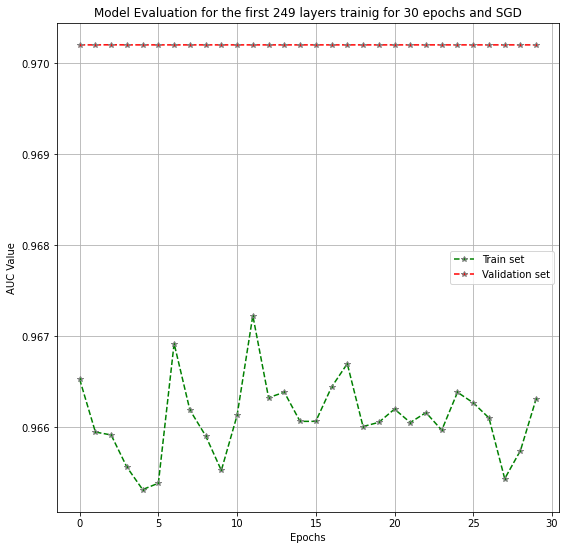

In [ ]:
plt.figure(figsize = (9,9))
plt.title(f'Model Evaluation for the first {N_layer} layers trainig for {Epochs} epochs and RMSprop')
plt.plot(hist_transfer.history[Evals[2]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(hist_transfer.history[Evals[5]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('AUC Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()

#GoogleNet


##Model Generation

In [ ]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [ ]:
def GoogLeNet():
    # input layer 
    input_layer = Input(shape = (224, 224, 3))
    input_layer = tf.keras.applications.inception_v3.preprocess_input(input_layer)

    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # convolutional layer: filters = 64, strides = 1
    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

    # convolutional layer: filters = 192, kernel_size = (3,3)
    X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)


    # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 5th Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 6th Inception block
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)


    # 7th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # 8th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # 9th Inception block
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

    # Global Average pooling layer 
    X = GlobalAveragePooling2D(name = 'GAPL')(X)

    # Dropoutlayer 
    X = Dropout(0.4)(X)

    # Dense 1
    X = Dense(1024 , activation = 'relu')(X)

    # output layer 
    X = Dense(1, activation = 'sigmoid')(X)

    # model
    model = Model(input_layer, X , name = 'GoogLeNet')

    return model

In [ ]:
GoogleNetModel = GoogLeNet()
GoogleNetModel.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_114 (Conv2D)            (None, 109, 109, 64  9472        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_26 (MaxPooling2D  (None, 54, 54, 64)  0           ['conv2d_114[1][0]']             
 )                                                                                        

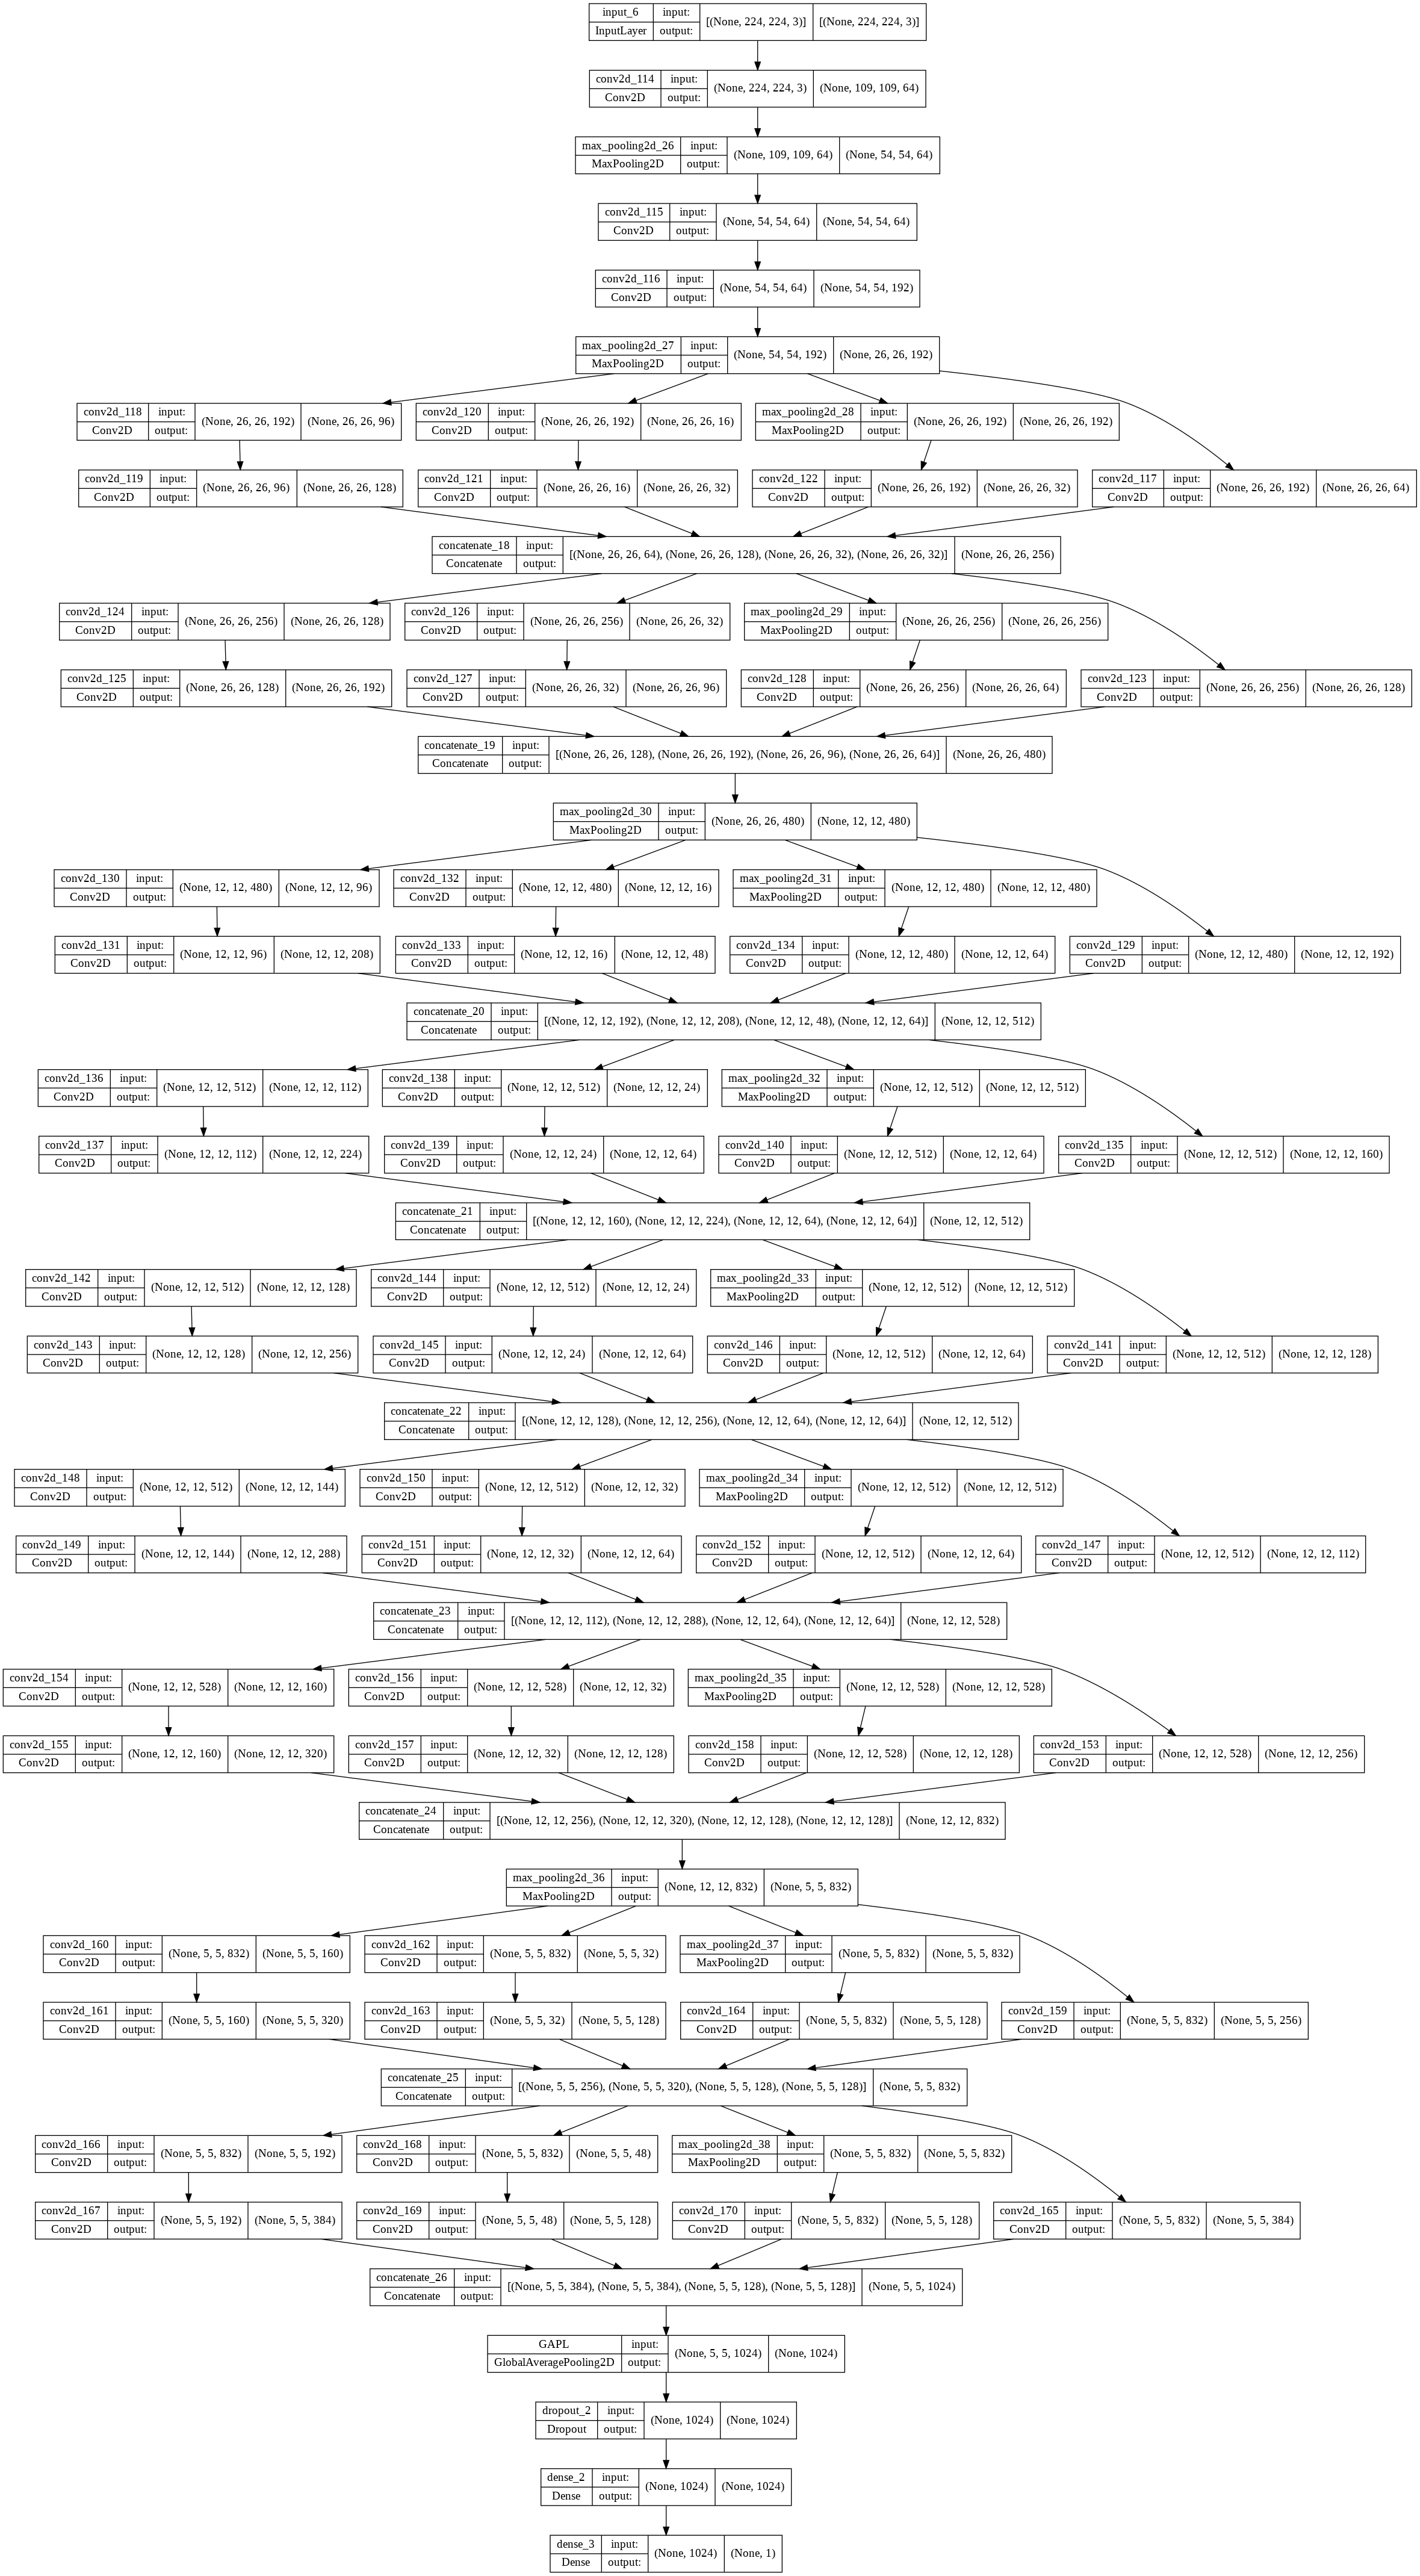

In [ ]:
tf.keras.utils.plot_model(GoogleNetModel,show_shapes=True)

##Train Phase (without Early Stopping)

In [ ]:
Opt = tf.keras.optimizers.RMSprop(learning_rate = 1e-5 , momentum = 0.9)

Loss = tf.keras.losses.BinaryCrossentropy()
metrics = [
    MT.BinaryAccuracy(),
    MT.AUC()
    ]
callback = [tf.keras.callbacks.ReduceLROnPlateau()]
GoogleNetModel.compile(
    optimizer=Opt,
    loss=Loss,
    metrics = metrics
    )


In [ ]:
with tf.device('/device:GPU:0'):
    GoogleNet_hist = GoogleNetModel.fit(
        train_ds,
        validation_data=val_ds,
        epochs = Epochs,
        callbacks = callback,
)  


Epoch 1/30
706/706 [==============================] - 86s 117ms/step - loss: 0.4089 - binary_accuracy: 0.8236 - auc_2: 0.8956 - val_loss: 0.2918 - val_binary_accuracy: 0.9021 - val_auc_2: 0.9546 - lr: 1.0000e-05
Epoch 2/30
706/706 [==============================] - 82s 116ms/step - loss: 0.3568 - binary_accuracy: 0.8540 - auc_2: 0.9208 - val_loss: 0.3071 - val_binary_accuracy: 0.8854 - val_auc_2: 0.9560 - lr: 1.0000e-05
Epoch 3/30
706/706 [==============================] - 83s 117ms/step - loss: 0.3375 - binary_accuracy: 0.8644 - auc_2: 0.9291 - val_loss: 0.2832 - val_binary_accuracy: 0.8969 - val_auc_2: 0.9718 - lr: 1.0000e-05
Epoch 4/30
706/706 [==============================] - 81s 115ms/step - loss: 0.3119 - binary_accuracy: 0.8746 - auc_2: 0.9398 - val_loss: 0.2420 - val_binary_accuracy: 0.9156 - val_auc_2: 0.9652 - lr: 1.0000e-05
Epoch 5/30
706/706 [==============================] - 81s 114ms/step - loss: 0.2904 - binary_accuracy: 0.8853 - auc_2: 0.9475 - val_loss: 0.2370 - val_b

In [ ]:
GoogleNetModel.save_weights('GoogleNetWeight_without_Early_stopping.h5')

### Model Performance Plot

In [ ]:
Evals = list(GoogleNet_hist.history.keys())

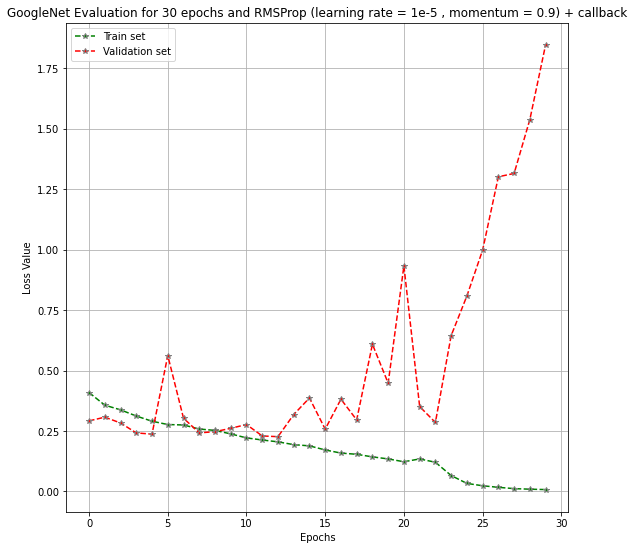

In [ ]:
plt.figure(figsize = (9,9))
plt.title(f'GoogleNet Evaluation for {Epochs} epochs and RMSProp (learning rate = 1e-5 , momentum = 0.9) + callback')
plt.plot(GoogleNet_hist.history[Evals[0]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(GoogleNet_hist.history[Evals[3]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('Loss Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()

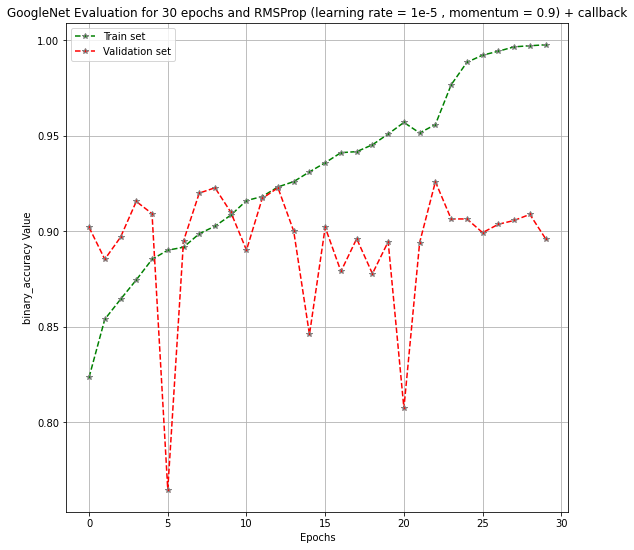

In [ ]:
plt.figure(figsize = (9,9))
plt.title(f'GoogleNet Evaluation for {Epochs} epochs and RMSProp (learning rate = 1e-5 , momentum = 0.9) + callback')
plt.plot(GoogleNet_hist.history[Evals[1]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(GoogleNet_hist.history[Evals[4]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('binary_accuracy Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()

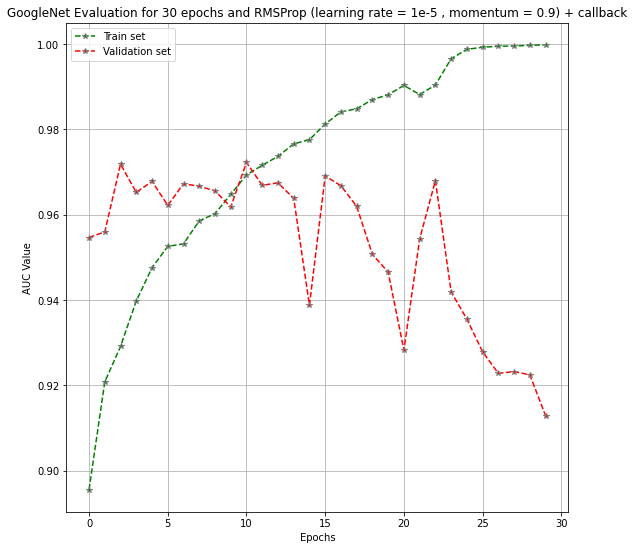

In [ ]:
plt.figure(figsize = (9,9))
plt.title(f'GoogleNet Evaluation for {Epochs} epochs and RMSProp (learning rate = 1e-5 , momentum = 0.9) + callback')
plt.plot(GoogleNet_hist.history[Evals[2]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(GoogleNet_hist.history[Evals[5]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('AUC Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()

## Train Phase (With Early Stopping)

In [ ]:
GoogleNetModel2 = tf.keras.models.clone_model(GoogleNetModel)

In [ ]:
Opt = tf.keras.optimizers.RMSprop(learning_rate = 1e-5 , momentum = 0.9)

Loss = tf.keras.losses.BinaryCrossentropy()
metrics = [
    MT.BinaryAccuracy(),
    MT.AUC()
    ]
callback = [tf.keras.callbacks.ReduceLROnPlateau() , tf.keras.callbacks.EarlyStopping(patience = 5 , restore_best_weights = True)]
GoogleNetModel2.compile(
    optimizer=Opt,
    loss=Loss,
    metrics = metrics
    )


In [ ]:
with tf.device('/device:GPU:0'):
    GoogleNet_hist = GoogleNetModel2.fit(
        train_ds,
        validation_data=val_ds,
        epochs = Epochs,
        callbacks = callback,
)  


Epoch 1/30
706/706 [==============================] - 85s 116ms/step - loss: 0.4453 - binary_accuracy: 0.8039 - auc_3: 0.8738 - val_loss: 0.3641 - val_binary_accuracy: 0.8834 - val_auc_3: 0.9458 - lr: 1.0000e-05
Epoch 2/30
706/706 [==============================] - 79s 111ms/step - loss: 0.3787 - binary_accuracy: 0.8419 - auc_3: 0.9108 - val_loss: 0.2795 - val_binary_accuracy: 0.9037 - val_auc_3: 0.9604 - lr: 1.0000e-05
Epoch 3/30
706/706 [==============================] - 79s 111ms/step - loss: 0.3445 - binary_accuracy: 0.8572 - auc_3: 0.9262 - val_loss: 0.3177 - val_binary_accuracy: 0.8953 - val_auc_3: 0.9630 - lr: 1.0000e-05
Epoch 4/30
706/706 [==============================] - 79s 112ms/step - loss: 0.3309 - binary_accuracy: 0.8664 - auc_3: 0.9319 - val_loss: 0.3520 - val_binary_accuracy: 0.8591 - val_auc_3: 0.9581 - lr: 1.0000e-05
Epoch 5/30
706/706 [==============================] - 79s 112ms/step - loss: 0.3138 - binary_accuracy: 0.8744 - auc_3: 0.9390 - val_loss: 0.2632 - val_b

In [ ]:
GoogleNetModel2.save_weights('GoogleNetWeight_with_Early_stopping.h5')

### Model Performance Plot

In [ ]:
Evals = list(GoogleNet_hist.history.keys())

In [ ]:
Evals

['loss',
 'binary_accuracy',
 'auc_4',
 'val_loss',
 'val_binary_accuracy',
 'val_auc_4',
 'lr']

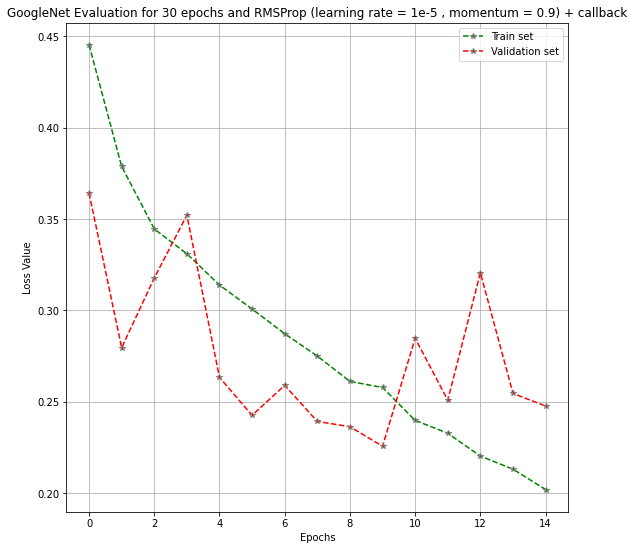

In [ ]:
plt.figure(figsize = (9,9))
plt.title(f'GoogleNet Evaluation for {Epochs} epochs and RMSProp (learning rate = 1e-5 , momentum = 0.9) + callback')
plt.plot(GoogleNet_hist.history[Evals[0]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(GoogleNet_hist.history[Evals[3]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('Loss Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()

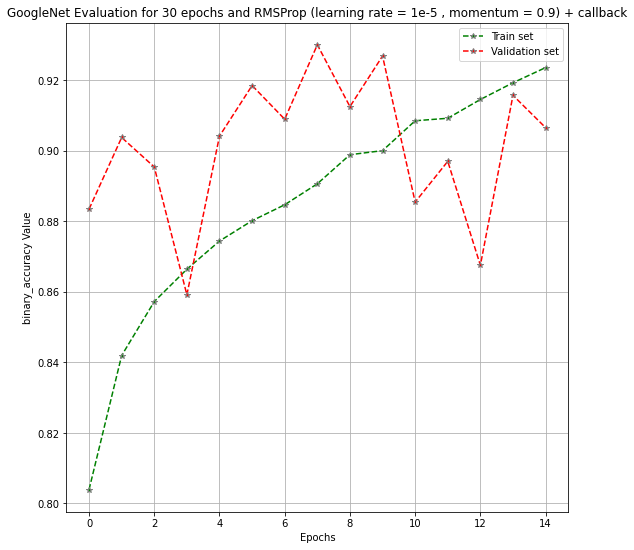

In [ ]:
plt.figure(figsize = (9,9))
plt.title(f'GoogleNet Evaluation for {Epochs} epochs and RMSProp (learning rate = 1e-5 , momentum = 0.9) + callback')
plt.plot(GoogleNet_hist.history[Evals[1]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(GoogleNet_hist.history[Evals[4]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('binary_accuracy Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()

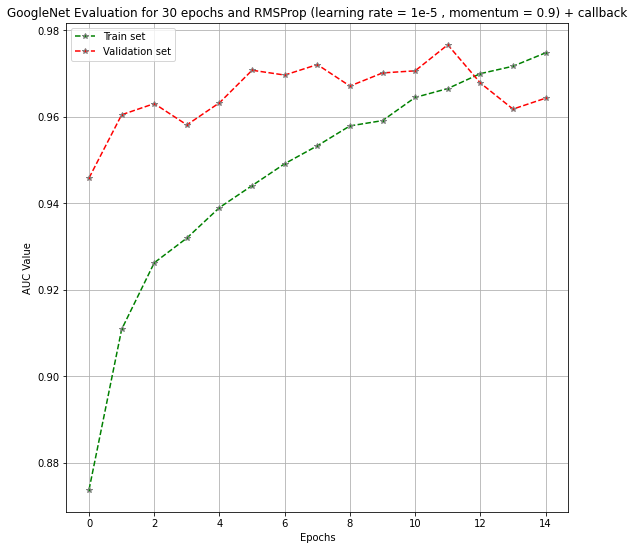

In [ ]:
plt.figure(figsize = (9,9))
plt.title(f'GoogleNet Evaluation for {Epochs} epochs and RMSProp (learning rate = 1e-5 , momentum = 0.9) + callback')
plt.plot(GoogleNet_hist.history[Evals[2]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(GoogleNet_hist.history[Evals[5]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('AUC Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()

# GoogleNet With Regularization

##Model Generation

In [ ]:
from keras.layers.normalization.batch_normalization import BatchNormalization
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu' , kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),  bias_regularizer=regularizers.L2(1e-4),  activity_regularizer=regularizers.L2(1e-5))(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),  bias_regularizer=regularizers.L2(1e-4),  activity_regularizer=regularizers.L2(1e-5))(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),  bias_regularizer=regularizers.L2(1e-4),  activity_regularizer=regularizers.L2(1e-5))(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),  bias_regularizer=regularizers.L2(1e-4),  activity_regularizer=regularizers.L2(1e-5))(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),  bias_regularizer=regularizers.L2(1e-4),  activity_regularizer=regularizers.L2(1e-5))(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),  bias_regularizer=regularizers.L2(1e-4),  activity_regularizer=regularizers.L2(1e-5))(path4)
  
  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [ ]:
def GoogLeNet():
    # input layer 
    input_layer = Input(shape = (224, 224, 3))
    input_layer = tf.keras.applications.inception_v3.preprocess_input(input_layer)

    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),  bias_regularizer=regularizers.L2(1e-4),  activity_regularizer=regularizers.L2(1e-5))(input_layer)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # convolutional layer: filters = 64, strides = 1
    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),  bias_regularizer=regularizers.L2(1e-4),  activity_regularizer=regularizers.L2(1e-5))(X)

    # convolutional layer: filters = 192, kernel_size = (3,3)
    X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),  bias_regularizer=regularizers.L2(1e-4),  activity_regularizer=regularizers.L2(1e-5))(X)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)


    # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 5th Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 6th Inception block
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)


    # 7th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # 8th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # 9th Inception block
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

    # Global Average pooling layer 
    X = GlobalAveragePooling2D(name = 'GAPL')(X)

    # Dropoutlayer 
    X = Dropout(0.4)(X)

    # Dense 1
    X = Dense(1024 , activation = 'relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),  bias_regularizer=regularizers.L2(1e-4),  activity_regularizer=regularizers.L2(1e-5))(X)

    # output layer 
    X = Dense(1, activation = 'sigmoid' , kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),  bias_regularizer=regularizers.L2(1e-4),  activity_regularizer=regularizers.L2(1e-5))(X)

    # model
    model = Model(input_layer, X , name = 'GoogLeNet')

    return model

In [ ]:
GoogleNetModel_withReg = GoogLeNet()
GoogleNetModel_withReg.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 109, 109, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 54, 54, 64)   0           ['conv2d[1][0]']                 
                                                                                          

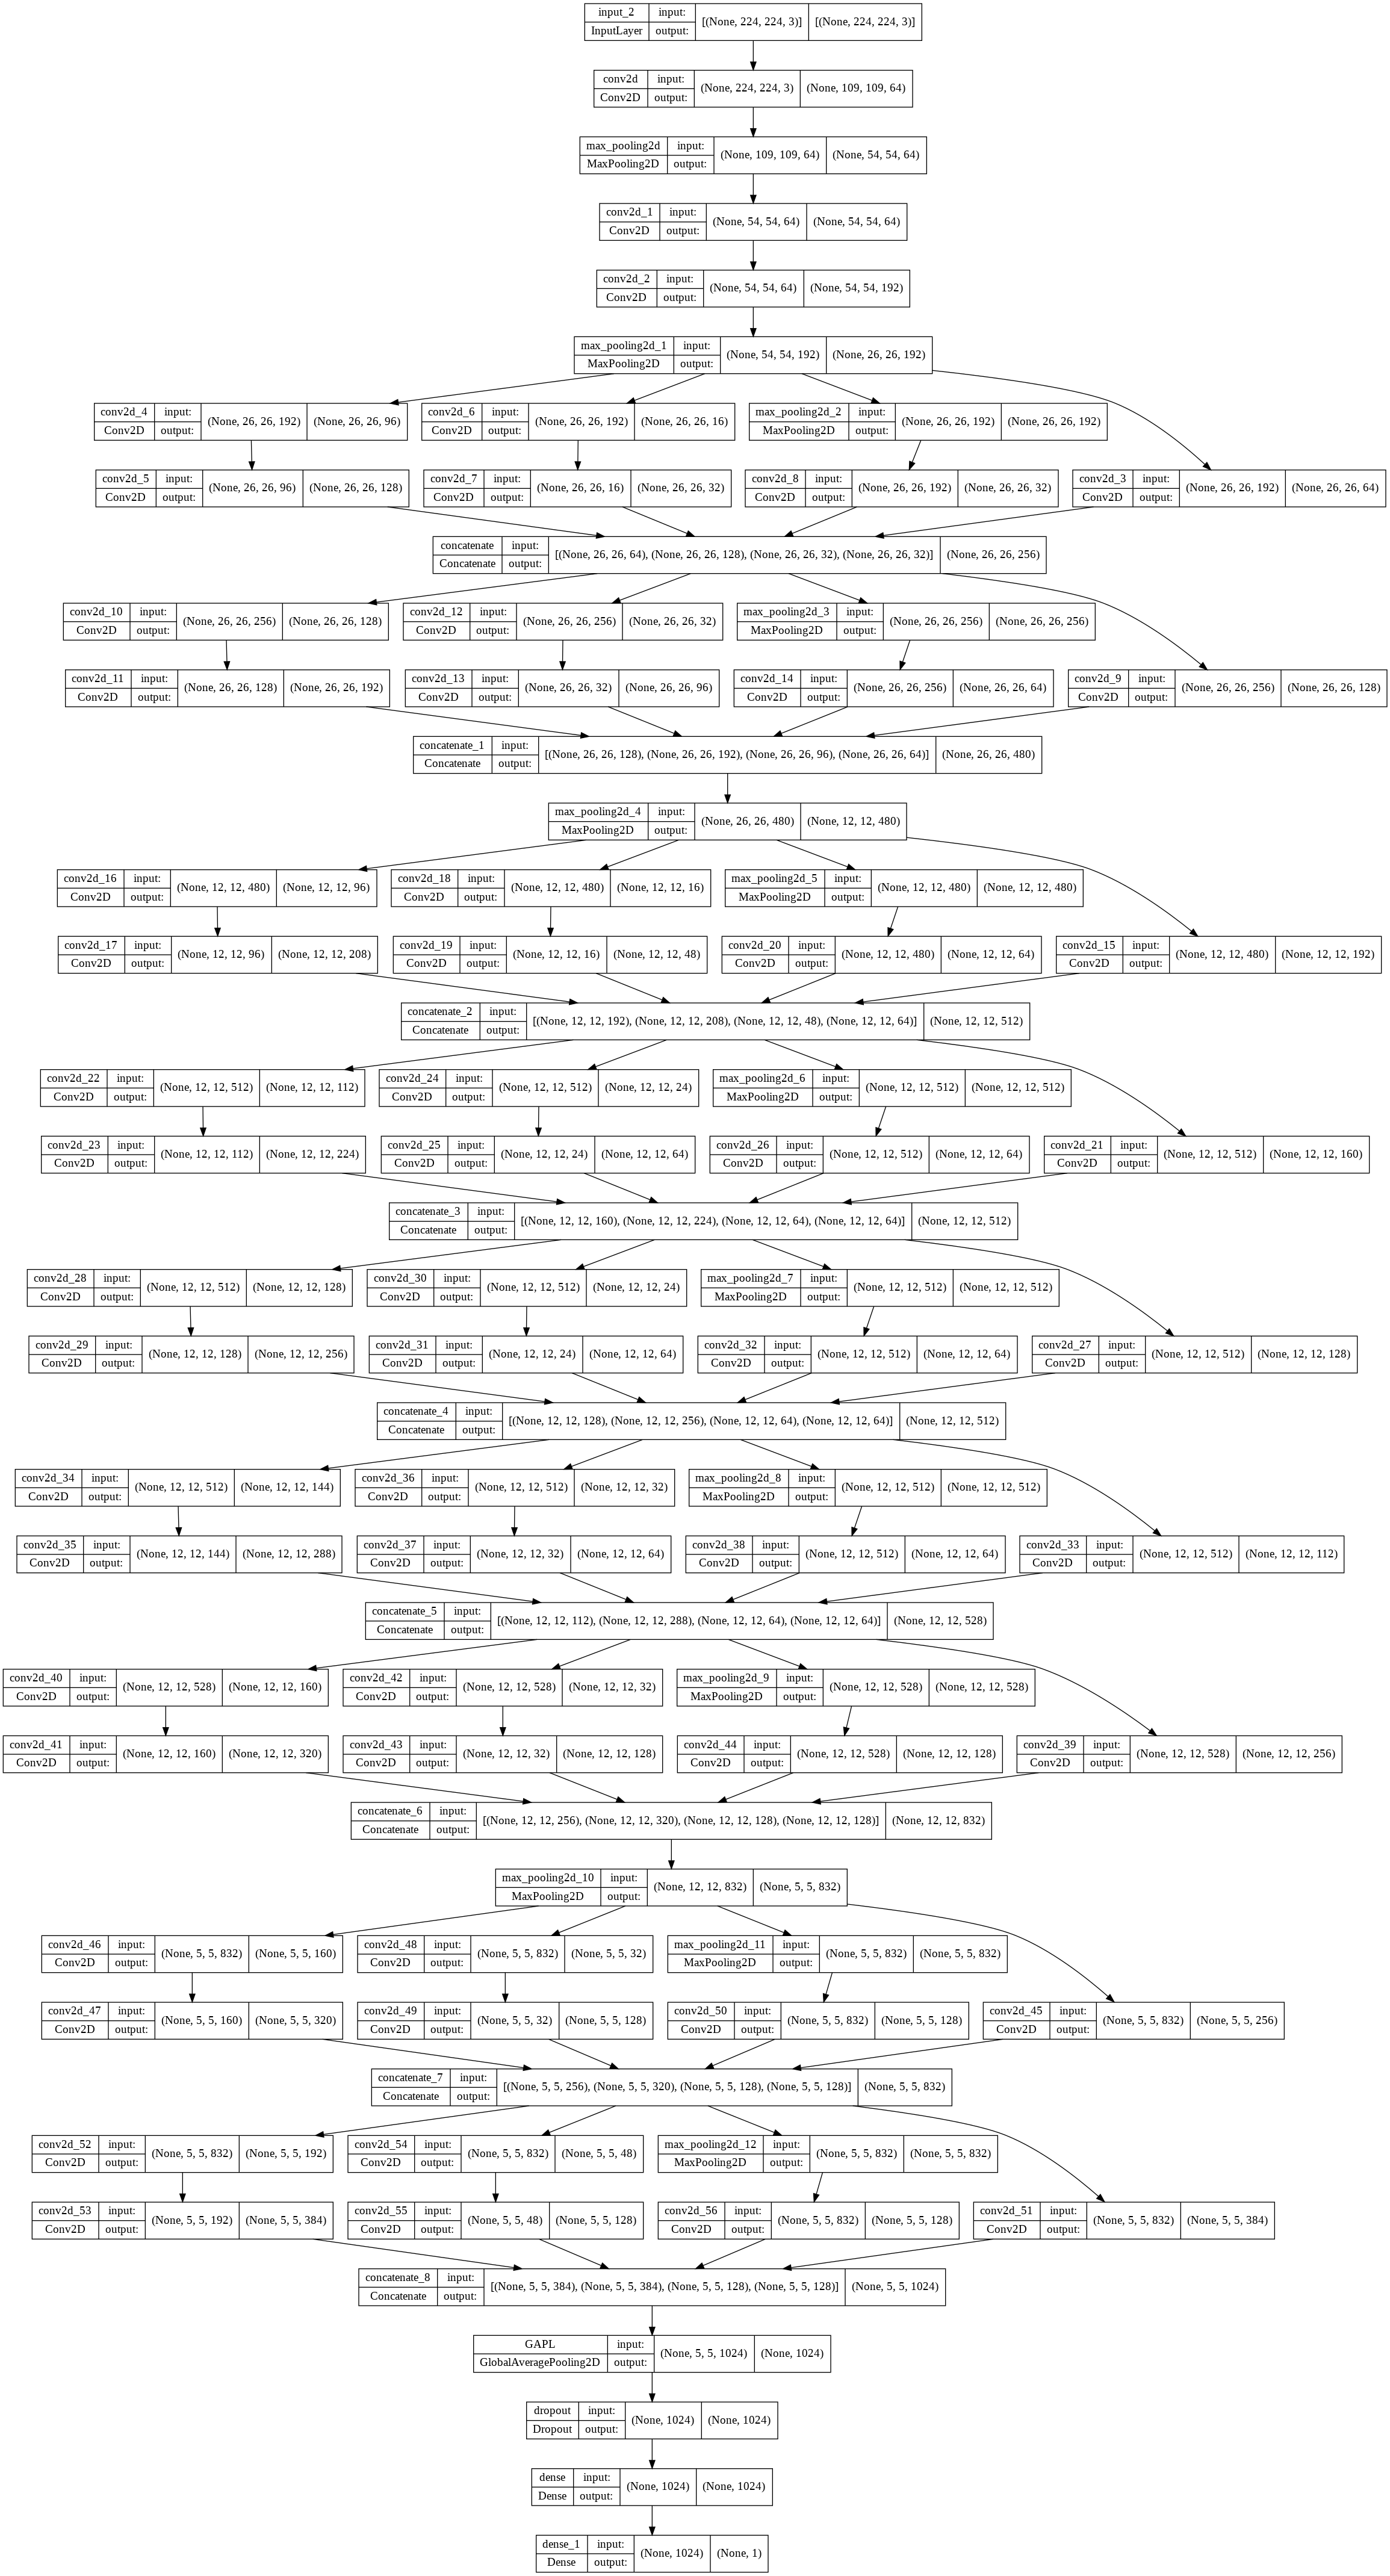

In [ ]:
tf.keras.utils.plot_model(GoogleNetModel_withReg,show_shapes=True)

##Train Phase

In [ ]:
Opt = tf.keras.optimizers.RMSprop(learning_rate = 1e-5 , momentum = 0.9)

Loss = tf.keras.losses.BinaryCrossentropy()
metrics = [
    MT.BinaryAccuracy(),
    MT.AUC()
    ]
callback = [tf.keras.callbacks.ReduceLROnPlateau() , tf.keras.callbacks.EarlyStopping(patience = 5 , restore_best_weights = True )]
GoogleNetModel_withReg.compile(
    optimizer=Opt,
    loss=Loss,
    metrics = metrics
    )


In [ ]:
with tf.device('/device:GPU:0'):
    GoogleNetModel_withReg_hist = GoogleNetModel_withReg.fit(
        train_ds,
        validation_data=val_ds,
        epochs = Epochs,
        callbacks = callback,
)  


Epoch 1/30
706/706 [==============================] - 134s 154ms/step - loss: 534.0544 - binary_accuracy: 0.6863 - auc: 0.7574 - val_loss: 3.1333 - val_binary_accuracy: 0.7907 - val_auc: 0.8451 - lr: 1.0000e-05
Epoch 2/30
706/706 [==============================] - 104s 147ms/step - loss: 2.9944 - binary_accuracy: 0.7632 - auc: 0.8288 - val_loss: 2.7635 - val_binary_accuracy: 0.8245 - val_auc: 0.8921 - lr: 1.0000e-05
Epoch 3/30
706/706 [==============================] - 104s 147ms/step - loss: 2.6619 - binary_accuracy: 0.7728 - auc: 0.8396 - val_loss: 2.4674 - val_binary_accuracy: 0.8365 - val_auc: 0.8915 - lr: 1.0000e-05
Epoch 4/30
706/706 [==============================] - 104s 147ms/step - loss: 2.3595 - binary_accuracy: 0.7851 - auc: 0.8547 - val_loss: 2.1932 - val_binary_accuracy: 0.8297 - val_auc: 0.8838 - lr: 1.0000e-05
Epoch 5/30
706/706 [==============================] - 104s 147ms/step - loss: 2.0959 - binary_accuracy: 0.7885 - auc: 0.8595 - val_loss: 1.9301 - val_binary_accur

### Model Performance Plot

In [ ]:
Evals = list(GoogleNetModel_withReg_hist.history.keys())

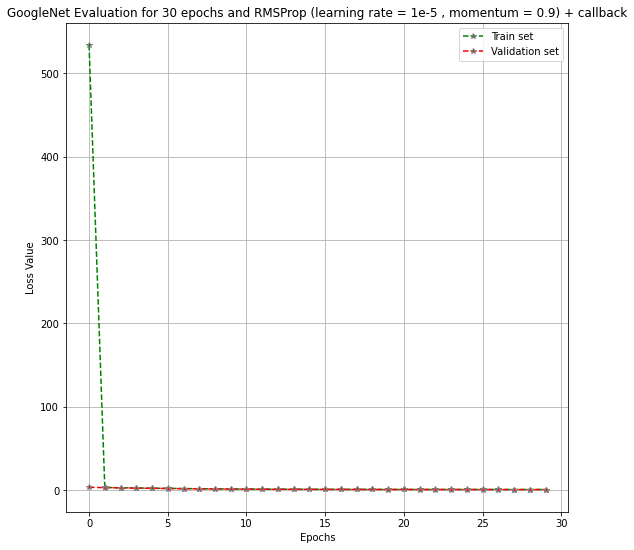

In [ ]:
plt.figure(figsize = (9,9))
plt.title(f'GoogleNet Evaluation for {Epochs} epochs and RMSProp (learning rate = 1e-5 , momentum = 0.9) + callback')
plt.plot(GoogleNetModel_withReg_hist.history[Evals[0]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(GoogleNetModel_withReg_hist.history[Evals[3]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('Loss Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()

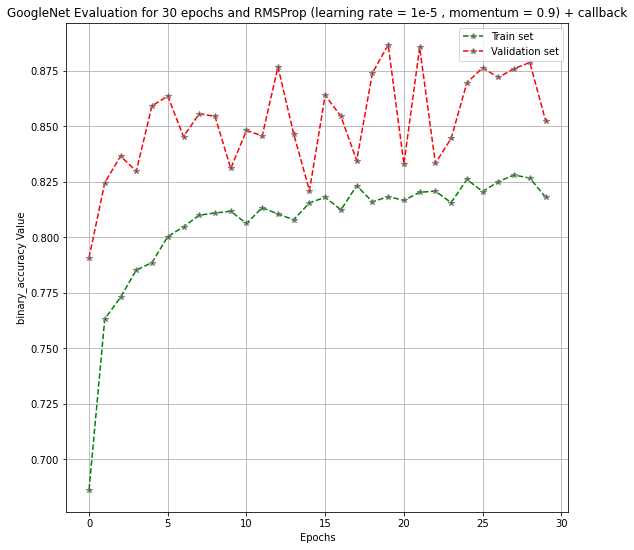

In [ ]:
plt.figure(figsize = (9,9))
plt.title(f'GoogleNet Evaluation for {Epochs} epochs and RMSProp (learning rate = 1e-5 , momentum = 0.9) + callback')
plt.plot(GoogleNetModel_withReg_hist.history[Evals[1]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(GoogleNetModel_withReg_hist.history[Evals[4]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('binary_accuracy Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()

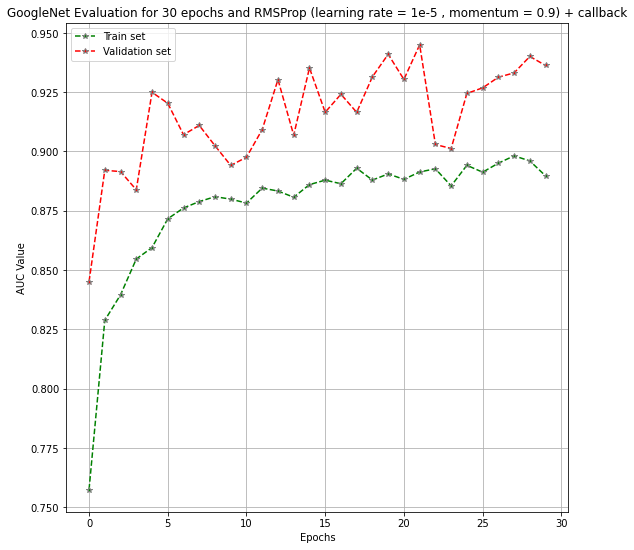

In [ ]:
plt.figure(figsize = (9,9))
plt.title(f'GoogleNet Evaluation for {Epochs} epochs and RMSProp (learning rate = 1e-5 , momentum = 0.9) + callback')
plt.plot(GoogleNetModel_withReg_hist.history[Evals[2]] , marker = '*' , linestyle = '--' , color = 'green' , markeredgecolor = 'gray' , label = 'Train set')
plt.plot(GoogleNetModel_withReg_hist.history[Evals[5]], marker = '*' , linestyle = '--' , color = 'red' , markeredgecolor = 'gray' , label = 'Validation set')
plt.legend()
plt.ylabel('AUC Value')
plt.xlabel('Epochs')
plt.grid()
plt.show()